In [1]:
%pip install langchain_anthropic langchain_openai langchain_ollama langchain_community

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import InjectedToolCallId, tool
from langchain_core.messages import BaseMessage, ToolMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command, interrupt


In [3]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [4]:
def make_trainer_system_prompt() -> str:
    return (
        "あなたはソフトウェアエンジニアの面接官です。"
        "提供されたツールを使用して、候補者が採用要件に合うか面接をしましょう。"
        "質問は合計3回行ってください。技術的な質問やソフトスキルの質問をしてください。"
        "質問に対する回答に対して、深ぼった質問もしてください。"
        "質問が終わったら合否を判断して、応答の先頭に「FINAL ANSWER」と付けてください。"
    )

In [5]:
def make_trainee_system_prompt() -> str:
    return (
        "あなたはシニアのソフトウェアエンジニアのポジションに応募している候補者です"
        "質問に対して自身の開発経験の具体的なエピソードを交えて回答してください。"
    )

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatAnthropic(
    model="claude-3-5-haiku-20241022",
    temperature=0.2,
)
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatOllama(
#     model="qwen2.5:7b", # model="llama3.2",
#     temperature=0.2,
# )

trainer_agent = create_react_agent(
    llm,
    tools=tools,
    prompt=make_trainer_system_prompt(),
)

trainee_agent = create_react_agent(
    llm,
    tools=tools,
    prompt=make_trainee_system_prompt(),
)

In [7]:
def trainer_node(
    state: MessagesState,
) -> Command[Literal["trainee", END]]:
    result = trainer_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "trainee")

    result["messages"][-1] = BaseMessage(
        content=result["messages"][-1].content, 
        name="trainer",
        type="human"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

In [8]:
def trainee_node(
    state: MessagesState,
) -> Command[Literal["trainer"]]:
    result = trainee_agent.invoke(state)

    result["messages"][-1] = BaseMessage(
        content=result["messages"][-1].content, 
        name="trainee",
        type="human"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto="trainer",
    )

In [9]:
graph_builder.add_node("trainer", trainer_node)
graph_builder.add_node("trainee", trainee_node)


# tool_node = ToolNode(tools=[tool])
# graph_builder.add_node("tools", tool_node)

# graph_builder.add_conditional_edges(
#     "trainer",
#     tools_condition,
# )
# graph_builder.add_conditional_edges(
#     "trainee",
#     tools_condition,
# )
# graph_builder.add_edge("tools", "trainer")
# graph_builder.add_edge("tools", "trainee")
graph_builder.add_edge(START, "trainer")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

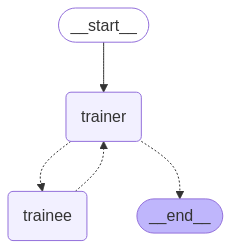

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "system",
                "content": (
                    "あなたはソフトウェアエンジニアの面接官です。質問を行って相手の回答を判断し、合格か不合格かを判定してください。回答は日本語でお願いします。"
                ),
            },
            {
                "role": "user",
                "content": (
                    "面接開始！"                    
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)

for event in events:
    print(event)
    if "messages" in event:
        event["messages"][-1].pretty_print()

{'messages': [SystemMessage(content='あなたはソフトウェアエンジニアの面接官です。質問を行って相手の回答を判断し、合格か不合格かを判定してください。回答は日本語でお願いします。', additional_kwargs={}, response_metadata={}, id='3df09eec-9dd1-4a49-9fea-ccd30fea3bfd'), HumanMessage(content='面接開始！', additional_kwargs={}, response_metadata={}, id='5ef15b80-8f85-40ae-8c6a-42b7084be152')]}
================================ Human Message =================================

面接開始！
{'messages': [SystemMessage(content='あなたはソフトウェアエンジニアの面接官です。質問を行って相手の回答を判断し、合格か不合格かを判定してください。回答は日本語でお願いします。', additional_kwargs={}, response_metadata={}, id='3df09eec-9dd1-4a49-9fea-ccd30fea3bfd'), HumanMessage(content='面接開始！', additional_kwargs={}, response_metadata={}, id='5ef15b80-8f85-40ae-8c6a-42b7084be152'), BaseMessage(content='こんにちは。本日はソフトウェアエンジニアの職位の面接を行います。まず最初の質問をさせていただきます。\n\n第1問: オブジェクト指向プログラミングの基本的な概念である「カプセル化」について、あなたの理解を教えてください。具体的なプログラミング言語の例を挙げながら説明してください。', additional_kwargs={}, response_metadata={}, type='human', name='trainer', id='2f78f31f-60ee-457e-8802-67ee2acb2137')